## Data Analysis Interview Challenge

###### [Part 1 ‐ Exploratory data analysis](#Part1)
###### [Part 2 ‐ Experiment and metrics design](#Part2)
###### [Part 3 ‐ Predictive modeling](#Part3)

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from IPython.display import clear_output

<div class="alert alert-block alert-info" id='Part1'>
    <h3><b>Part 1 ‐ Exploratory data analysis</b></h3>
<h4>The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.
    </h4></div>

In [2]:
logins = pd.read_json('./logins.json')

### Verify Data

In [3]:
logins.login_time.describe(datetime_is_numeric=True)

count                            93142
mean     1970-02-26 19:09:39.779648278
min                1970-01-01 20:12:16
25%         1970-02-04 10:37:19.750000
50%         1970-03-01 06:33:05.500000
75%         1970-03-22 04:01:10.750000
max                1970-04-13 18:57:38
Name: login_time, dtype: object

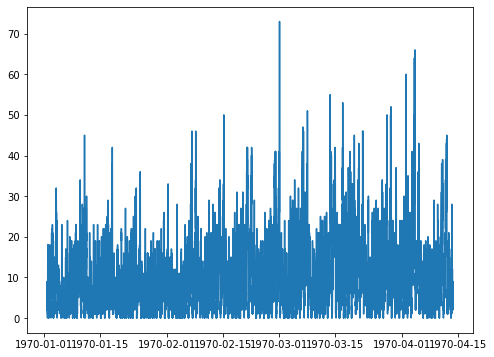

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
groupedLogins = logins.resample('15Min', on='login_time').count()
groupedLogins.columns = ['count']
plt.plot(groupedLogins)
groupedLogins = groupedLogins.reset_index()
plt.show()

<div class="alert alert-block alert-success">
    <h4>Data seems complete across the range of dates provided</h4>
</div>

### Plot patterns of Demand

In [5]:
#Tag unique days
groupedLogins['Month-Day'] = groupedLogins['login_time'].dt.strftime('%m-%d')
#Tag unique weeks
groupedLogins['Week'] =  groupedLogins['login_time'].dt.strftime('%U')

startOfTime = datetime(1970,1,1)

In [6]:
#Plot multiple lines based on unique identifier: 'groupName'
def AddLinesToPlot(loginsDf, groupName, subplot):
    for x in groupedLogins[groupName].unique():

        sub = groupedLogins[groupedLogins[groupName]==x][['login_time','count']]
        start = sub['login_time'].min()
        start = datetime(start.year,start.month,start.day)
        subplot.plot((sub['login_time']-start)+startOfTime,sub['count'])

##### Plot daily cycles

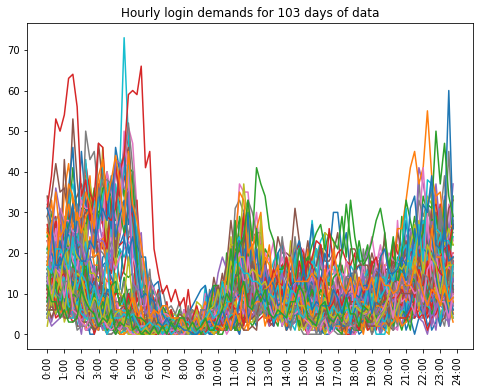

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
AddLinesToPlot(groupedLogins, 'Month-Day',ax)
hours=np.array(range(0,25))/24
hoursLabels=["{0}:00".format(x) for x in range(25)]
plt.title("Hourly login demands for {0} days of data".format(len(groupedLogins['Month-Day'].unique())))
plt.xticks(ticks = hours, labels=hoursLabels,rotation = 90)
plt.show()

<div class="alert alert-block alert-success">
    <p>
        <ol>
             <li>Hourly demand starts to peak from 8PM and continues til 5Am</li>
             <li>There is a lull in activity from 6AM to around 10:30AM</li>
             <li>Another peak occurs around 11AM to 12PM, followed by steady login activity to the late night peak</li>
        </ol>
</div>

<div class="alert alert-block alert-success">
    <h4>The activity shown here is potentially questionable, though could be correct.  An overnight peak that continues to 6AM does seem to contradict a normal sleep cycle, so I would verify that the timestamps are correct, and in the timezone of the users represented </h4>
</div>

##### Plot weekly cycles

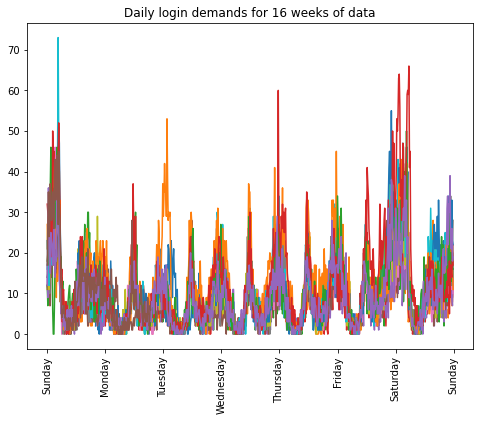

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
AddLinesToPlot(groupedLogins, 'Week',ax)

daysLabels=["Sunday", "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
(ticks, labels)=plt.xticks()

plt.title("Daily login demands for {0} weeks of data".format(len(groupedLogins['Week'].unique())))
plt.xticks(ticks=ticks,labels=daysLabels,rotation = 90)
plt.show()

<div class="alert alert-block alert-success">
        <ol>
             <li>Demand peaks on weekend days of Friday, Saturday, and Sunday with levels of activity ranked in that order</li>
             <li>There is a slight lull in activity on Mondyas</li>
             <li>The rest of the week shows the 12 hour cycle of demand shown before, with steady activity levels</li>
        </ol>
</div>

<div class="alert alert-block alert-info" id='Part2'>
    <h3><b>Part 2 ‐ Experiment and metrics design</b></h3>
<h4>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.</h4>
    <h4>However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs
    </h4></div>

<div class="alert alert-block alert-info">1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?</div>

The metric I would choose to monitor the success of this initiative is the absolute value of the log of the ratio of Gotham jobs to Metropolis jobs for each driver.

In the current state, drivers are partial to one city or another, meaning this ratio will be far from 1, either much greater or a small decimal.  Taking the log of this ratio will normalize these values to a constent range, e.g. a driver doing 100 Gotham jobs to 1 job in Metropolis will have a ratio of 100, and a logged ratio of 2 and a driver doing 100 Metropolis jobs to 1 job in Gotham will have a ratio of .01 and a logged ratio of -2.  Taking the absolute value of this logged ratio will equate favoring one city to favoing another, resulting in a value of 2 for both example cases.  The goal of the experiment would be to reduce the sum of this metric across all drivers

I would chose this metric over total bridge crossings because the goal is balancing a drivers jobs between the two cities and while increasing the total bridge crossings is an indicator of this balance, it is not a direct measure of it.

<div class="alert alert-block alert-info">
    2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success.</div>

I would implement an A/B test by taking a representative sample of the driver partners and presenting them with the offer to reimburse toll costs for a limited ammount of time, say about a month. 

After this time, compare the metric described above between the group that recieved the offer and the metrics of the remaining population of driver parteners, using the null hypothesis that reimbursing the tolls had no statistical result on the driver partner's availability in both cities.  

If the null hypothesis cannot be rejected, I would recommend that the city operations team discontinue the offer with the driver's of the sample and pursue other experiments.  If the null hypothesis can be rejected, i.e. the metric (absolute value of the log of the ratio of Gotham jobs to Metropolis jobs) was significantly different for the drivers who recieved the offer, I would recommend that the drivers who recieved the offer continue to recieve reimbursed tolls to see whether the effect is short lived, and to extend the offer to a new sample of drivers to see if the results can be completed.

If the successful results can be repeated for the new sample, and they indicate a continued success past the experiment time, I would recommend that the city operations team release the offer to the remaining drivers.

<div class="alert alert-block alert-info" id='Part3'>
    <h3><b>Part 3 ‐ Predictive modeling
</b></h3>
<h4>Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
    </h4></div>

In [9]:
challenge = pd.read_json('./ultimate_data_challenge.json')
challenge.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

<div class="alert alert-block alert-info">
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
</div>

In [10]:
import warnings
warnings.filterwarnings('ignore')

challenge['last_trip_date'] = pd.to_datetime(challenge['last_trip_date'])
challenge['signup_date'] = pd.to_datetime(challenge['signup_date'])
challenge.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [11]:
thirtyDaysAgo = challenge.last_trip_date.max() - pd.Timedelta(pd.offsets.Day(30))
challenge['Retained'] = challenge['last_trip_date'] >= thirtyDaysAgo

In [12]:
challenge['Retained'].value_counts()

False    31196
True     18804
Name: Retained, dtype: int64

<div class="alert alert-block alert-success">
<b>The date shows that 37% of users were retained.  This is using the assumption that "the preceding 30 days" is equivalent to "the maximum 'last_trip_date' and 30 days before".  This seems a reasonable assumption given the data in the set.</b>
</div>

<div class="alert alert-block alert-info">
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

</div>

##### Normalize and Prep Data

In [13]:
challengeSub = challenge.loc[:, ~(challenge.columns.isin(['last_trip_date','signup_date']))]

for x in challengeSub.select_dtypes(include=np.number).columns.tolist():
    challengeSub.loc[:,(x)] = (challengeSub[x]-challengeSub[x].mean())/challengeSub[x].std()
    
challengeSub['signup_week'] = [str(x) for x in challenge['signup_date'].dt.week.values]
challengeSub.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,5.000000e+04,4.187800e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,4.979900e+04
mean,-3.131007e-16,2.988165e-13,1.142876e-13,1.588919e-14,1.561911e-14,2.721584e-15,6.077965e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.006828e-01,-5.834011e+00,-3.362649e-01,-4.433899e-01,-1.643032e+00,-1.015676e+00,-8.458845e+00
25%,-6.006828e-01,-4.884829e-01,-3.362649e-01,-4.433899e-01,-7.450098e-01,-5.916621e-01,-1.749869e-01
50%,-3.370173e-01,4.834313e-01,-3.362649e-01,-4.433899e-01,1.557088e-01,-3.358519e-01,4.966773e-01
75%,1.903138e-01,6.454170e-01,-1.113801e-01,-1.250255e-02,1.053731e+00,2.002982e-01,4.966773e-01
max,3.235751e+01,6.454170e-01,3.114761e+01,4.566929e+00,1.053731e+00,2.718652e+01,4.966773e-01


In [14]:
challengePrepped = pd.get_dummies(challengeSub)

In [15]:
#Find NA Values
challengePrepped.isna().sum()

trips_in_first_30_days       0
avg_rating_of_driver      8122
avg_surge                    0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
Retained                     0
city_Astapor                 0
city_King's Landing          0
city_Winterfell              0
phone_Android                0
phone_iPhone                 0
signup_week_1                0
signup_week_2                0
signup_week_3                0
signup_week_4                0
signup_week_5                0
dtype: int64

In [16]:
#Only NA are for numeric columnns 'avg_rating_of_driver' and 
# 'avg_rating_by_driver'.  These columsn have been normalized, 
# so fill NA with 0, which is equivalent to setting to the mean
challengePrepped = challengePrepped.fillna(0)

##### Import Classificaiton Models and Metrics

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score, f1_score
from sklearn.model_selection import train_test_split

##### Define Funtion to try and score several models

In [18]:
def tryModels(x_tr, x_te, y_tr, y_te):

    for y_col in y_tr.columns:
        models = []
        models.append(['SVC',SVC()])
        models.append(['NB_Gauss',GaussianNB()])
        models.append(['SGD',SGDClassifier()])
        models.append(['KNN',KNeighborsClassifier()])
        models.append(['DecisionTree',DecisionTreeClassifier()])
        models.append(['RandForrest',RandomForestClassifier()])
        models.append(['GradBoost', GradientBoostingClassifier()])

        modelMetrics =[]   

        for mod in models:
            thisModelDict = {}
            thisModelDict['name']= mod[0]
            
            model=mod[1]
            model.fit(x_tr, y_tr[y_col])
            ypredTrain = model.predict(x_tr)
            ypred = model.predict(x_te)
            
            
            thisModelDict[y_col+'_Av_Precision_TrainSet']=average_precision_score(y_tr[y_col],ypredTrain)
            thisModelDict[y_col+'_F1_TrainSet']=f1_score(y_tr[y_col],ypredTrain)
            thisModelDict[y_col+'_score_TrainSet']= model.score(x_tr, y_tr[y_col])
        

            thisModelDict[y_col+'_Av_Precision_testSet']=average_precision_score(y_te[y_col],ypred)
            thisModelDict[y_col+'_F1_testSet']=f1_score(y_te[y_col],ypred)
            thisModelDict[y_col+'_score_testSet']= model.score(x_te, y_te[y_col])
        
            modelMetrics.append(thisModelDict)


        modDf = pd.DataFrame(modelMetrics)
        for col in modDf.columns:
            if(col=='name'):
                continue

            modDf.plot.bar(x='name', y=col, rot=90)
            plt.show()

##### Split into Traininng and Test Sets

In [19]:
X = challengePrepped.loc[:, challengePrepped.columns!='Retained']
y = challengePrepped[['Retained']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Test Various Models

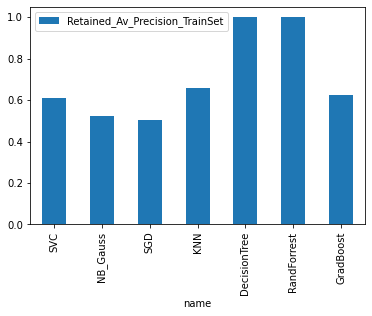

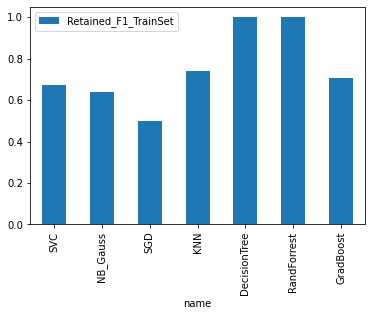

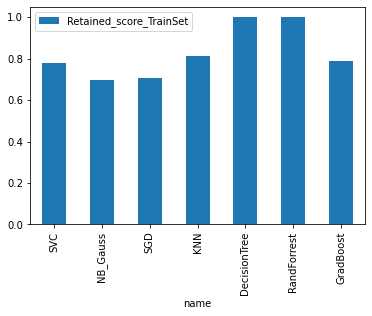

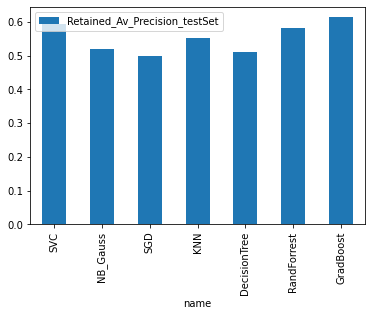

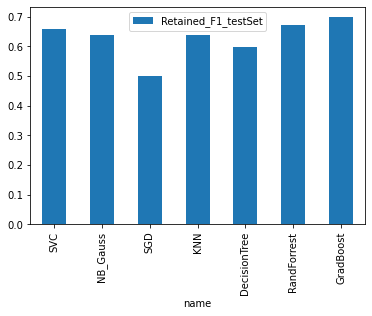

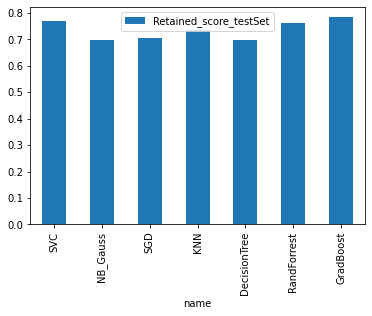

In [20]:
tryModels(X_train, X_test, y_train, y_test)

<div class="alert alert-block alert-success">
<b>Tested several Classificaiton Machine Learning Models to compare performance between them, and determine which model scheme works best with this dataset.  This approach gives a better perspective of performance than running a single model alone.</b>
</div>

<div class="alert alert-block alert-success">
<b>Best performance on Training Set were Decision Tree and Random Forrest, though they appear to be overfitting as this performance does not translate to the test set as well. There does seem to be some viable models however, for instance SVC (.6 Av Precision, .65 F1 Score, and .775 score) and KNN (.55 Av Precision, .65 F1 Score, and .7 score) on the Test set.  These scores could likely be improved by optimizing model metrics, but should be able to make fairly reliable predictions.  Key model features are listed below for several models. </b>
</div>



##### Code for feature importances - imported from SciKit Learn

In [21]:
#This code imported from Scikit-learn with minor modification
#  https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

import time

def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    
    
    t1 = time.time()
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    t2 =time.time()
    
    #print('Jumble time:', t2-t1, 'seconds')
    
    permuted_score = model.score(X_permuted, y)
    t3 = time.time()
    #print('Jumble score time:', t3-t2, 'seconds')
    return permuted_score


def get_feature_importance(model, X, y, curr_feat, baseScore):
    """ compare the score when curr_feat is permuted """

    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseScore - permuted_score_train
    return feature_importance

def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    t1 = time.time()
    baseline_score_train = model.score(X, y)
    t2 = time.time()
    
    for curr_feat in X.columns:
        print(curr_feat)
        list_feature_importance = []
        for n_round in range(n_repeats):
            print("round {0}".format(n_round))
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat,baseline_score_train))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}


def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(10,8))

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

### Feature Importances

##### Random Forrest

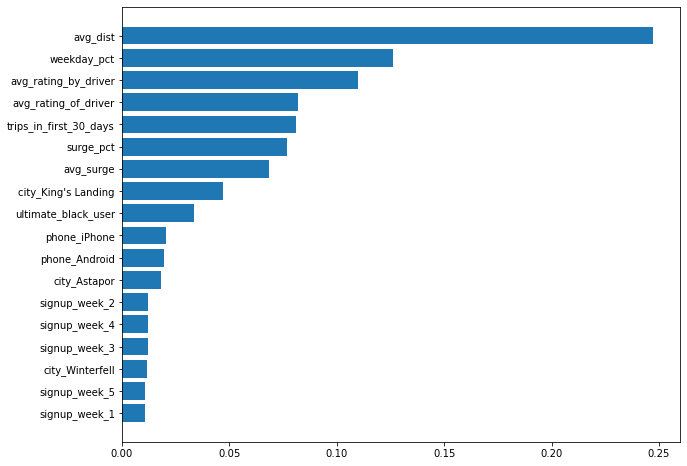

In [22]:
model = RandomForestClassifier()
model.fit(X_train, y_train['Retained'])
importances =model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

##### Gradient Boosting

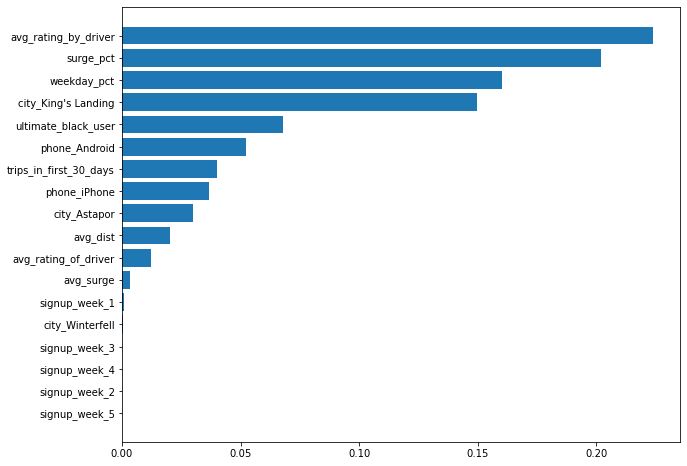

In [25]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train['Retained'])
importances =model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

##### K Nearest Neighbors

In [23]:
modelKNN = KNeighborsClassifier()
modelKNN.fit(X_train, y_train['Retained'])
perm_importance_result_train = permutation_importance(modelKNN, X_train, y_train['Retained'], n_repeats=3)

clear_output(wait=True)

trips_in_first_30_days
round 0
round 1
round 2
avg_rating_of_driver
round 0
round 1
round 2
avg_surge
round 0
round 1
round 2
surge_pct
round 0
round 1
round 2
ultimate_black_user
round 0
round 1
round 2
weekday_pct
round 0
round 1
round 2
avg_dist
round 0
round 1
round 2
avg_rating_by_driver
round 0
round 1
round 2
city_Astapor
round 0
round 1
round 2
city_King's Landing
round 0
round 1
round 2
city_Winterfell
round 0
round 1
round 2
phone_Android
round 0
round 1
round 2
phone_iPhone
round 0
round 1
round 2
signup_week_1
round 0
round 1
round 2
signup_week_2
round 0
round 1
round 2
signup_week_3
round 0
round 1
round 2
signup_week_4
round 0
round 1
round 2
signup_week_5
round 0
round 1
round 2


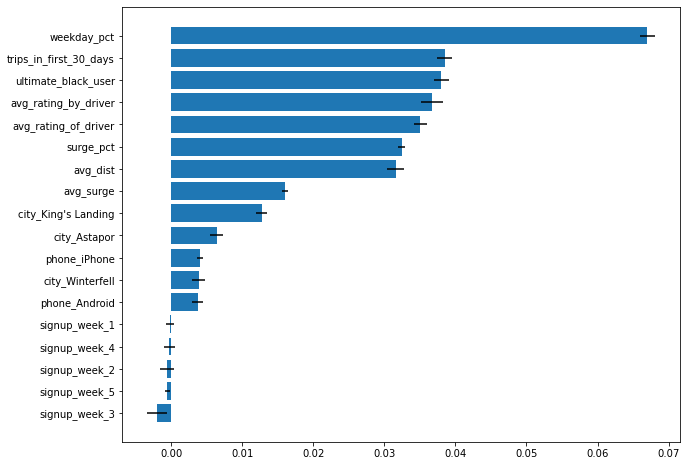

In [24]:
plot_feature_importances(perm_importance_result_train, X_train.columns)

<div class="alert alert-block alert-success">
<b>Top features that contribute to performance are</b>
    <ul>
        <li>weekday_pct</li>
        <li>avg_rating_by_driver</li>
        <li>surge_pct</li>
    </ul>
</div>

<div class="alert alert-block alert-success">
Ultimate can leverage these insights by determining what values of these parameters correspond to better retainment, i.e. are they positively or negatively correlated, and offering deals to those customers that are at high risk of not being retained or advertise rewards for customers with good retainment metrics to encorage that behavior.
</div>